In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Subset, Dataset, DataLoader
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# device = torch.device('cpu')

class MoannaDataset(Dataset):
    def __init__(self, data_file, label_file):
        self.data = pd.read_csv(data_file, sep=',', header=0, index_col=0).values
        self.label = pd.read_csv(label_file, header=0, index_col=0).values[:,1]
        self.data = torch.from_numpy(self.data).float().to(device)
        self.label = self.label.astype(int)
        self.label = torch.from_numpy(self.label).long().to(device)

    def __len__(self):
        return len(self.label)

    def __getitem__(self, idx):
        return self.data[idx], self.label[idx]


class MoannaModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, dropout=0.2):
        super(MoannaModel, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        # self.batchnorm = nn.BatchNorm1d(hidden_dim)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout)
        self.fc2 = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        out = self.fc1(x)
        # out = self.batchnorm(out)
        out = self.relu(out)
        out = self.dropout(out)
        out = self.fc2(out)
        return out

In [2]:

data_file = '/home/intern/WarmUpProject/p-tcga_binary_mutation.csv'
label_file = '/home/intern/WarmUpProject/pp-TCGA-clinical.csv'

dataset = MoannaDataset(data_file, label_file)

batch_size = 256


In [3]:
idx = torch.randperm(len(dataset))

split_point = int(0.7 * len(idx))

train_idx = list(idx[:split_point])
test_idx = list(idx[split_point:])

train_dataset = Subset(dataset, train_idx)
test_dataset = Subset(dataset, test_idx)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False) 
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False) 


In [4]:
len(train_dataset)

7028

In [5]:
train_dataset[7000][0]

tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')

In [6]:
len(train_dataset[0][0])

13322

In [7]:
def k_fold_cross_validation(train_dataset, test_loader, k, num_epochs, batch_size, learning_rate, hidden_dim, device, shuffle=True):
    
    n_samples = len(train_dataset)
    fold_size = n_samples // k
    indices = np.random.permutation(n_samples)

    Model = []
    Train_acc = []
    Val_acc = []
    Test_acc = []
    
    for i in range(k):
        print(f"Processing fold {i+1}/{k}...")
        
        start = i * fold_size
        end = (i + 1) * fold_size
        
        traintrain_indices = list(np.concatenate([indices[:start], indices[end:]]))
        trainval_indices = list(indices[start:end])
        
        # Create data loaders for training and validation
        traintrain_dataset = Subset(train_dataset, traintrain_indices)
        trainval_dataset = Subset(train_dataset, trainval_indices)
        traintrain_loader = DataLoader(traintrain_dataset, batch_size=batch_size, shuffle=shuffle)
        trainval_loader = DataLoader(trainval_dataset, batch_size=batch_size, shuffle=False)    
        
        # Hyperparameters
        # learning_rate = 0.1
        # hidden_dim = 512

        # Initialize model and transfer to GPU
        model = MoannaModel(len(train_dataset[0][0]), hidden_dim, 33).to(device)
        

        # Define loss function and optimizer
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.SGD(model.parameters(), lr=learning_rate)
        
        # Train the model
        train_losses = []
        train_accs = []
        val_accs = []
        test_accs = []
        
        for epoch in range(num_epochs):
            # Train
            model.train()
            train_loss = 0.0
            train_acc = 0.0
            for j, (inputs, labels) in enumerate(traintrain_loader):
                optimizer.zero_grad()
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()

                train_loss += loss.item()
                train_acc += accuracy_score(torch.argmax(outputs, dim=1).cpu(), labels.cpu())

            train_loss /= len(traintrain_loader)
            train_acc /= len(traintrain_loader)
            train_losses.append(train_loss)
            train_accs.append(train_acc)

            # Validate
            model.eval()
            val_acc = 0.0
            with torch.no_grad():
                for inputs, labels in trainval_loader:
                    outputs = model(inputs)
                    val_acc += accuracy_score(torch.argmax(outputs, dim=1).cpu(), labels.cpu())
                val_acc /= len(trainval_loader)
                val_accs.append(val_acc)

            # # Check if this is the best model so far
            # if val_acc > best_accuracy:
            #     best_accuracy = val_acc
            #     best_model = model.__class__(train_dataset.data.shape[1], hidden_dim, 33).to(device)
            #     best_model.load_state_dict(model.state_dict())
                
            # Test
            model.eval()
            test_acc = 0.0
            with torch.no_grad():
                for inputs, labels in test_loader:
                    outputs = model(inputs)
                    test_acc += accuracy_score(torch.argmax(outputs, dim=1).cpu(), labels.cpu())
                test_acc /= len(test_loader)
                test_accs.append(test_acc)
                
            print(f"Fold {i+1}/{k}, Epoch {epoch+1}: Train Loss={train_loss:.4f}, "
                  f"Train Acc={train_acc:.4f}, Val Acc={val_acc:.4f}, Test Acc={test_acc:.4f}")
            
        MModel = model.__class__(len(train_dataset[0][0]), hidden_dim, 33).to(device)
        MModel.load_state_dict(model.state_dict())
        Model.append(MModel)
        
        Train_acc.append(train_accs[-1])
        Val_acc.append(val_accs[-1])
        Test_acc.append(test_accs[-1])
        
        # Plot loss and accuracy for this fold
        plt.figure(figsize=(10, 5))
        plt.subplot(1, 2, 1)
        plt.plot(train_losses, label='Train Loss')
        plt.legend()
        plt.title(f"Fold {i+1} Loss")

        plt.subplot(1, 2, 2)
        plt.plot(train_accs, label='Train Acc')
        plt.plot(val_accs, label='Val Acc')
        plt.plot(test_accs, label='Test Acc')
        plt.legend()
        plt.title(f"Fold {i+1} Accuracy")
        plt.show()

    return Model, Train_acc, Val_acc, Test_acc

Processing fold 1/5...
Fold 1/5, Epoch 1: Train Loss=3.4674, Train Acc=0.0533, Val Acc=0.1347, Test Acc=0.1121
Fold 1/5, Epoch 2: Train Loss=3.3942, Train Acc=0.1284, Val Acc=0.1366, Test Acc=0.1165
Fold 1/5, Epoch 3: Train Loss=3.3215, Train Acc=0.1464, Val Acc=0.1779, Test Acc=0.1593
Fold 1/5, Epoch 4: Train Loss=3.2495, Train Acc=0.1694, Val Acc=0.1962, Test Acc=0.1782
Fold 1/5, Epoch 5: Train Loss=3.1812, Train Acc=0.1851, Val Acc=0.2133, Test Acc=0.1853
Fold 1/5, Epoch 6: Train Loss=3.1245, Train Acc=0.1912, Val Acc=0.2185, Test Acc=0.1906
Fold 1/5, Epoch 7: Train Loss=3.0713, Train Acc=0.2012, Val Acc=0.2100, Test Acc=0.1900
Fold 1/5, Epoch 8: Train Loss=3.0213, Train Acc=0.2109, Val Acc=0.2270, Test Acc=0.1963
Fold 1/5, Epoch 9: Train Loss=2.9679, Train Acc=0.2206, Val Acc=0.2355, Test Acc=0.2055
Fold 1/5, Epoch 10: Train Loss=2.9180, Train Acc=0.2276, Val Acc=0.2335, Test Acc=0.2095
Fold 1/5, Epoch 11: Train Loss=2.8635, Train Acc=0.2536, Val Acc=0.2486, Test Acc=0.2230
Fold 1/

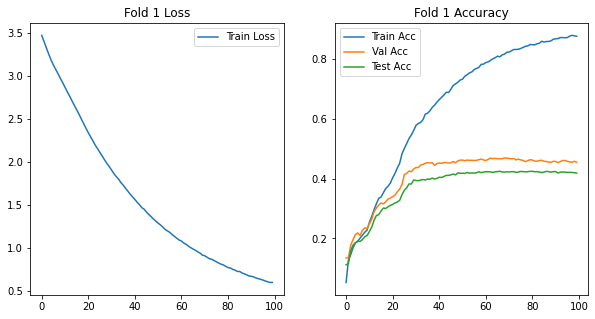

Processing fold 2/5...
Fold 2/5, Epoch 1: Train Loss=3.4633, Train Acc=0.0961, Val Acc=0.1476, Test Acc=0.1300
Fold 2/5, Epoch 2: Train Loss=3.3749, Train Acc=0.1307, Val Acc=0.1567, Test Acc=0.1443
Fold 2/5, Epoch 3: Train Loss=3.2912, Train Acc=0.1458, Val Acc=0.1665, Test Acc=0.1575
Fold 2/5, Epoch 4: Train Loss=3.2143, Train Acc=0.1692, Val Acc=0.1913, Test Acc=0.1764
Fold 2/5, Epoch 5: Train Loss=3.1448, Train Acc=0.1875, Val Acc=0.1906, Test Acc=0.1832
Fold 2/5, Epoch 6: Train Loss=3.0850, Train Acc=0.1967, Val Acc=0.1939, Test Acc=0.1913
Fold 2/5, Epoch 7: Train Loss=3.0305, Train Acc=0.2049, Val Acc=0.1979, Test Acc=0.1900
Fold 2/5, Epoch 8: Train Loss=2.9757, Train Acc=0.2148, Val Acc=0.2024, Test Acc=0.2022
Fold 2/5, Epoch 9: Train Loss=2.9287, Train Acc=0.2261, Val Acc=0.2076, Test Acc=0.2137
Fold 2/5, Epoch 10: Train Loss=2.8742, Train Acc=0.2406, Val Acc=0.2128, Test Acc=0.2197
Fold 2/5, Epoch 11: Train Loss=2.8257, Train Acc=0.2493, Val Acc=0.2252, Test Acc=0.2226
Fold 2/

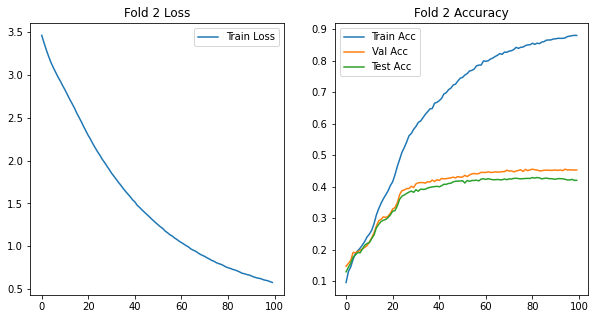

Processing fold 3/5...
Fold 3/5, Epoch 1: Train Loss=3.4621, Train Acc=0.0859, Val Acc=0.1130, Test Acc=0.1215
Fold 3/5, Epoch 2: Train Loss=3.3925, Train Acc=0.1355, Val Acc=0.1176, Test Acc=0.1357
Fold 3/5, Epoch 3: Train Loss=3.3164, Train Acc=0.1493, Val Acc=0.1260, Test Acc=0.1398
Fold 3/5, Epoch 4: Train Loss=3.2383, Train Acc=0.1677, Val Acc=0.1384, Test Acc=0.1535
Fold 3/5, Epoch 5: Train Loss=3.1705, Train Acc=0.1830, Val Acc=0.1495, Test Acc=0.1607
Fold 3/5, Epoch 6: Train Loss=3.1076, Train Acc=0.1917, Val Acc=0.1593, Test Acc=0.1766
Fold 3/5, Epoch 7: Train Loss=3.0495, Train Acc=0.2006, Val Acc=0.1619, Test Acc=0.1847
Fold 3/5, Epoch 8: Train Loss=2.9951, Train Acc=0.2187, Val Acc=0.1658, Test Acc=0.1865
Fold 3/5, Epoch 9: Train Loss=2.9423, Train Acc=0.2305, Val Acc=0.1762, Test Acc=0.1981
Fold 3/5, Epoch 10: Train Loss=2.8894, Train Acc=0.2432, Val Acc=0.1807, Test Acc=0.2027
Fold 3/5, Epoch 11: Train Loss=2.8353, Train Acc=0.2569, Val Acc=0.1841, Test Acc=0.2067
Fold 3/

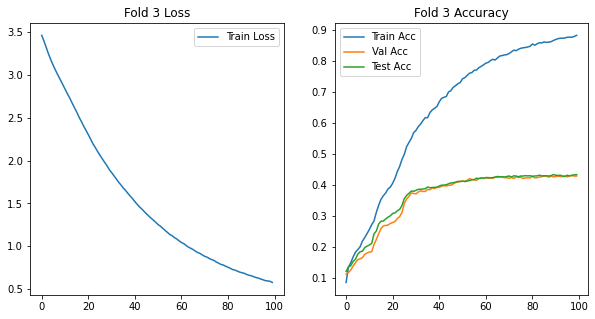

Processing fold 4/5...
Fold 4/5, Epoch 1: Train Loss=3.4713, Train Acc=0.0659, Val Acc=0.1051, Test Acc=0.1159
Fold 4/5, Epoch 2: Train Loss=3.3920, Train Acc=0.1281, Val Acc=0.1274, Test Acc=0.1367
Fold 4/5, Epoch 3: Train Loss=3.3092, Train Acc=0.1487, Val Acc=0.1333, Test Acc=0.1426
Fold 4/5, Epoch 4: Train Loss=3.2317, Train Acc=0.1613, Val Acc=0.1404, Test Acc=0.1560
Fold 4/5, Epoch 5: Train Loss=3.1644, Train Acc=0.1780, Val Acc=0.1541, Test Acc=0.1707
Fold 4/5, Epoch 6: Train Loss=3.1053, Train Acc=0.1894, Val Acc=0.1712, Test Acc=0.1832
Fold 4/5, Epoch 7: Train Loss=3.0504, Train Acc=0.2052, Val Acc=0.1666, Test Acc=0.1773
Fold 4/5, Epoch 8: Train Loss=2.9963, Train Acc=0.2058, Val Acc=0.1790, Test Acc=0.1999
Fold 4/5, Epoch 9: Train Loss=2.9477, Train Acc=0.2250, Val Acc=0.1803, Test Acc=0.1995
Fold 4/5, Epoch 10: Train Loss=2.8934, Train Acc=0.2323, Val Acc=0.1842, Test Acc=0.1989
Fold 4/5, Epoch 11: Train Loss=2.8424, Train Acc=0.2423, Val Acc=0.1901, Test Acc=0.2067
Fold 4/

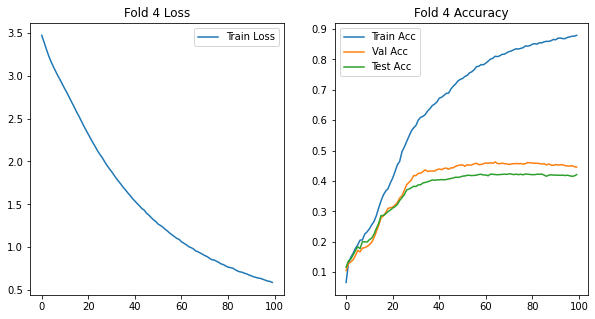

Processing fold 5/5...
Fold 5/5, Epoch 1: Train Loss=3.4722, Train Acc=0.1074, Val Acc=0.1170, Test Acc=0.1120
Fold 5/5, Epoch 2: Train Loss=3.3994, Train Acc=0.1279, Val Acc=0.1235, Test Acc=0.1270
Fold 5/5, Epoch 3: Train Loss=3.3215, Train Acc=0.1560, Val Acc=0.1478, Test Acc=0.1494
Fold 5/5, Epoch 4: Train Loss=3.2415, Train Acc=0.1722, Val Acc=0.1602, Test Acc=0.1642
Fold 5/5, Epoch 5: Train Loss=3.1678, Train Acc=0.1882, Val Acc=0.1752, Test Acc=0.1802
Fold 5/5, Epoch 6: Train Loss=3.1009, Train Acc=0.1988, Val Acc=0.1785, Test Acc=0.1816
Fold 5/5, Epoch 7: Train Loss=3.0445, Train Acc=0.2038, Val Acc=0.1851, Test Acc=0.1904
Fold 5/5, Epoch 8: Train Loss=2.9887, Train Acc=0.2155, Val Acc=0.1916, Test Acc=0.1939
Fold 5/5, Epoch 9: Train Loss=2.9365, Train Acc=0.2257, Val Acc=0.1916, Test Acc=0.1989
Fold 5/5, Epoch 10: Train Loss=2.8829, Train Acc=0.2375, Val Acc=0.1981, Test Acc=0.2067
Fold 5/5, Epoch 11: Train Loss=2.8351, Train Acc=0.2526, Val Acc=0.2073, Test Acc=0.2185
Fold 5/

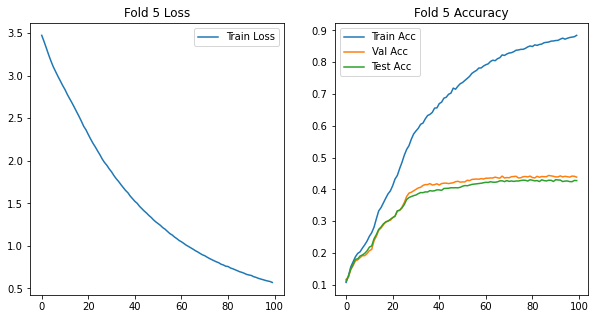

In [8]:
num_epochs = 100
k = 5
learning_rate = 0.1
hidden_dim = 128

Model, Train_acc, Val_acc, Test_acc = k_fold_cross_validation(train_dataset, test_loader, k, num_epochs, batch_size, learning_rate, hidden_dim, device=device, shuffle=True)

In [9]:
Model

[MoannaModel(
   (fc1): Linear(in_features=13322, out_features=128, bias=True)
   (relu): ReLU()
   (dropout): Dropout(p=0.2, inplace=False)
   (fc2): Linear(in_features=128, out_features=33, bias=True)
 ),
 MoannaModel(
   (fc1): Linear(in_features=13322, out_features=128, bias=True)
   (relu): ReLU()
   (dropout): Dropout(p=0.2, inplace=False)
   (fc2): Linear(in_features=128, out_features=33, bias=True)
 ),
 MoannaModel(
   (fc1): Linear(in_features=13322, out_features=128, bias=True)
   (relu): ReLU()
   (dropout): Dropout(p=0.2, inplace=False)
   (fc2): Linear(in_features=128, out_features=33, bias=True)
 ),
 MoannaModel(
   (fc1): Linear(in_features=13322, out_features=128, bias=True)
   (relu): ReLU()
   (dropout): Dropout(p=0.2, inplace=False)
   (fc2): Linear(in_features=128, out_features=33, bias=True)
 ),
 MoannaModel(
   (fc1): Linear(in_features=13322, out_features=128, bias=True)
   (relu): ReLU()
   (dropout): Dropout(p=0.2, inplace=False)
   (fc2): Linear(in_features=12

In [10]:
Train_acc

[0.8746218830511594,
 0.8799356482333457,
 0.8817565041866029,
 0.8792642390504232,
 0.8842681783676849]

In [11]:
Val_acc

[0.4541927083333333,
 0.452984375,
 0.4286145833333333,
 0.44551041666666663,
 0.43850520833333334]

In [12]:
Test_acc

[0.41798857868020306,
 0.42030027231387485,
 0.43319056683587137,
 0.4209513139805415,
 0.42775420368020306]

In [13]:
TRAIN_acc = np.mean(Train_acc)
print(f"{TRAIN_acc:.4f}")

0.8800


In [14]:
VAL_acc = np.mean(Val_acc)
print(f"{VAL_acc:.4f}")

0.4440


In [15]:
TEST_acc = np.mean(Test_acc)
print(f"{TEST_acc:.4f}")

0.4240


In [16]:
def test_model(model, test_loader):
    model.eval()
    test_acc = 0.0
    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = model(inputs)
            test_acc += accuracy_score(torch.argmax(outputs, dim=1).cpu(), labels.cpu())

        test_acc /= len(test_loader)

    print(f"Test Accuracy: {test_acc:.4f}")

In [17]:
for i in range(5):
    test_model(Model[i], test_loader)

Test Accuracy: 0.4180
Test Accuracy: 0.4203
Test Accuracy: 0.4332
Test Accuracy: 0.4210
Test Accuracy: 0.4278


In [18]:
for inputs, labels in train_loader:
    outputs = Model[1](inputs)
    print(torch.argmax(outputs, dim=1))
    print(labels)

tensor([ 1,  1, 11,  1, 13,  1, 19,  1,  2, 29, 23, 27,  1,  6,  1,  1, 18, 27,
        24,  6,  1,  7, 27, 10, 16, 27, 21,  7, 23,  0,  2,  0,  4,  7, 15, 10,
        21, 25, 10,  8, 11, 27,  1, 10, 19, 24, 10, 16, 27,  2, 14, 27,  1,  7,
        15, 14, 21, 27, 10,  1, 22, 14, 13, 19, 15, 27,  0,  8, 29, 13, 18, 16,
        16, 15,  8, 24, 30, 16,  7,  6, 13, 21,  7, 29,  0, 29, 27,  1,  0,  1,
         7, 19, 19,  4, 10, 25, 21, 10,  4,  1, 23, 19,  1,  6, 27, 13,  8,  6,
        27,  7, 21, 21,  8, 13, 16,  6, 27, 29, 18, 29,  7, 27,  4,  0,  1, 10,
        27, 25, 14,  4, 24,  1, 21, 21,  0, 15, 27,  0,  7, 13,  8,  0,  4, 10,
        27, 16,  4, 24, 29,  0,  4, 27,  1, 27, 14, 16, 25,  6, 29, 18, 27, 27,
        27, 19, 10,  8, 18,  2, 23, 21, 15,  1, 14, 13, 27, 13,  2, 13, 27, 27,
        15, 18, 18, 29, 29, 29, 16,  7,  1, 21,  8, 15, 16, 29, 27, 27, 29, 27,
        29,  4, 10, 13, 14, 10,  8, 27, 11, 27,  4, 18,  1, 24,  1, 11, 27, 16,
        18, 18,  8,  8, 27, 21, 13, 25, 